In [40]:
pip install requests


In [41]:
import requests
import pandas as pd
key = 'dc8c6242b79f3aea9e063b023eaa70d23ebbbb3e'
# Tiingo--Documentation--Authentication

In [92]:
url = f'https://api.tiingo.com/tiingo/daily/AAPL/prices?startDate=2018-01-01&endDate=2023-01-01&token={key}'
response = requests.get(url)
#Make a Request to the Tiingo API: Construct the URL to request data for a specific stock (e.g., AAPL) and send the request:


In [93]:


# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)

    # Convert DataFrame to CSV
    df.to_csv('AAPL_data.csv', index=False)
    print("Data saved to AAPL_data.csv")
else:
    print("Error fetching data:", response.status_code, response.text)
#A status code of 200 means that the server successfully processed the request and returned the expected data in HTTP

Data saved to AAPL_data.csv


In [94]:
df=pd.read_csv('AAPL_data.csv')
df.head(5)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2018-01-02T00:00:00.000Z,172.26,172.30,169.26,170.16,25048048,40.568298,40.577719,39.861780,40.073735,100192192,0.0,1.0
1,2018-01-03T00:00:00.000Z,172.23,174.55,171.96,172.53,28819653,40.561233,41.107608,40.497647,40.631885,115278612,0.0,1.0
2,2018-01-04T00:00:00.000Z,173.03,173.47,172.08,172.54,22211345,40.749638,40.853261,40.525907,40.634240,88845380,0.0,1.0
3,2018-01-05T00:00:00.000Z,175.00,175.37,173.05,173.44,23016177,41.213585,41.300723,40.754348,40.846196,92064708,0.0,1.0
4,2018-01-08T00:00:00.000Z,174.35,175.61,173.93,174.35,20134092,41.060506,41.357244,40.961594,41.060506,80536368,0.0,1.0


In [95]:
df.shape

(1259, 13)

In [96]:
#It resets the index of the DataFrame. By default, when you fetch data from an API or create a DataFrame, the index may not be a simple range (0, 1, 2, ...). For example, the index might be dates or other identifiers.
#The result of reset_index() is a new DataFrame where the old index becomes a regular column and a new default integer index is created.
df1=df.reset_index()['close']

In [47]:
#df1

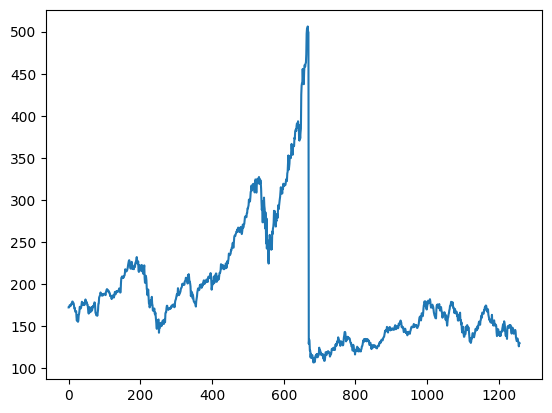

In [97]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [98]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
##If the input data is not normalized or standardized, the model may converge slowly or even fail to learn properly.
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
#np.array(df1): Converts df1 (which should be a Pandas Series or similar) into a NumPy array
##.reshape(-1, 1): Reshapes the array to be two-dimensional, which is required by MinMaxScaler.
#Here, -1 means "infer the number of rows" and 1 means there is one column.


In [50]:
#print(df1)

In [99]:
#Data partition
training_size=int(len(df1)*0.65) # setting training data size as 65% of length of df1
test_size=len(df1)-training_size # setting test data size as remaining 35% of length of df1
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
#This selects all rows from the beginning (index 0) up to (but not including) the training_size index
#The : indicates that all columns are included in this selection

In [100]:
training_size,test_size

(818, 441)

In [101]:
#The function create_dataset you provided is designed to convert a time series dataset into a format suitable for training models like LSTMs.
#It does this by creating input-output pairs where the input consists of a sequence of past values and the output is the next value in the sequence.


In [102]:
import numpy
# train_data and test_data are in array format.convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [103]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [104]:
print(x_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [105]:
print(x_test.shape), print(y_test.shape)

(340, 100)
(340,)


(None, None)

In [106]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)
#x_train.shape[0]: This represents the number of samples in the training set.
#x_train.shape[1]: This represents the number of time steps in each sample.
#1: This indicates that we have one feature per time step

In [107]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [108]:
model=Sequential() #initializing a sequential model, which is a linear stack of layers
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
#50: This indicates the number of units (neurons) in the LSTM layer
#return_sequences=True: This parameter means that this layer will return the full sequence of outputs for each input, which is necessary for stacking more LSTM layers on top.
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))#dense (fully connected) layer with a single neuron, which is typically used for regression tasks (like predicting a single value).
model.compile(loss='mean_squared_error',optimizer='adam')
#Optimizer: adam is a popular optimization algorithm that adjusts the learning rate throughout training for better convergence.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - loss: 0.0605 - val_loss: 0.0031
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0139 - val_loss: 0.0011
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - loss: 0.0115 - val_loss: 0.0028
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0146 - val_loss: 0.0015
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0089 - val_loss: 4.3200e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0087 - val_loss: 7.0001e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - loss: 0.0044 - val_loss: 4.3502e-04
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.0073 - val_loss: 3.2896e-04
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0054 - val_loss: 3.2750e-04
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0054 - val_loss: 7.8732e-04
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0059 - val_loss: 3.3128e-04
Epoch 12/100


In [111]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [112]:
#prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [113]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [114]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

249.6459638542767

In [115]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

178.70108976333125

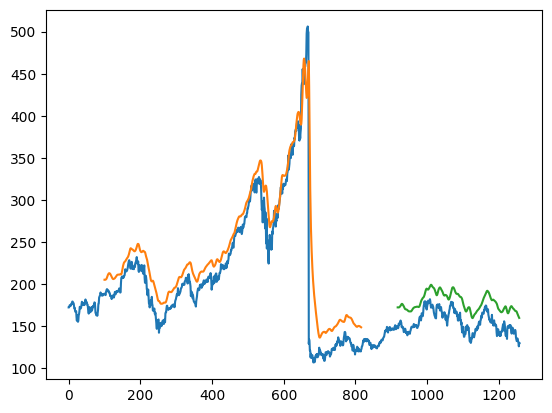

In [116]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan #This creates an empty array (trainPredictPlot) with the same shape as df1 (your original dataset) and fills it with NaN values.
#This is to ensure that only the predictions will be plotted, while the rest of the array remains blank.
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [117]:
len(test_data)

441

In [119]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape
#test_data[341:]: This selects all the elements in test_data starting from index 341 to the end. This is useful when you want to make a prediction using the last part of your test dataset.

(1, 100)

In [120]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.15629304946775202,
 0.1544145272385723,
 0.16345648090169063,
 0.16618659987476514,
 0.16578584846587346,
 0.1695929868503444,
 0.1685911083281152,
 0.16200375704445835,
 0.15211020663744512,
 0.15125860989355033,
 0.15201001878522225,
 0.15827175954915462,
 0.142216656230432,
 0.1366061365059486,
 0.13041953663118344,
 0.12618659987476516,
 0.12804007514088916,
 0.1226549780839073,
 0.1194489668127739,
 0.12303068252974325,
 0.1192736380713838,
 0.12656230432060112,
 0.14174076393237317,
 0.1177207263619286,
 0.12140262993112083,
 0.11403882279273636,
 0.10985597996242946,
 0.11932373199749524,
 0.1253850970569818,
 0.1174201628052598,
 0.11496556042579836,
 0.10917971195992482,
 0.11003130870381966,
 0.11251095804633682,
 0.10770194113963677,
 0.08926737633061982,
 0.07854727614276763,
 0.08919223544145266,
 0.09833437695679392,
 0.09908578584846583,
 0.09665623043206006,
 0.08328115216030052,
 0.08410770194113959,
 0.08050093926111451,
 0.07889793362554787,
 0.09054477144646211,


In [121]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.1285983]
101
1 day input [0.15441453 0.16345648 0.1661866  0.16578585 0.16959299 0.16859111
 0.16200376 0.15211021 0.15125861 0.15201002 0.15827176 0.14221666
 0.13660614 0.13041954 0.1261866  0.12804008 0.12265498 0.11944897
 0.12303068 0.11927364 0.1265623  0.14174076 0.11772073 0.12140263
 0.11403882 0.10985598 0.11932373 0.1253851  0.11742016 0.11496556
 0.10917971 0.11003131 0.11251096 0.10770194 0.08926738 0.07854728
 0.08919224 0.09833438 0.09908579 0.09665623 0.08328115 0.0841077
 0.08050094 0.07889793 0.09054477 0.07899812 0.08909205 0.09244834
 0.09272386 0.09154665 0.10126487 0.10672511 0.11396368 0.10647464
 0.09507827 0.12247965 0.11646838 0.10973075 0.09565435 0.08025047
 0.07899812 0.08035066 0.08180338 0.07020664 0.10026299 0.10735128
 0.10379461 0.10820288 0.10507201 0.10990607 0.11133375 0.10311835
 0.10855354 0.11078272 0.10336882 0.09362555 0.08598622 0.10316844
 0.10386976 0.10261741 0.09966187 0.0903444  0.08541014 0.08969317
 0.08846587 0.09430182 0.09675642 0

In [122]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
#np.arange(start, stop) generates an array of evenly spaced values from start to stop - 1.

In [123]:
import matplotlib.pyplot as plt

In [124]:
len(df1)

1259

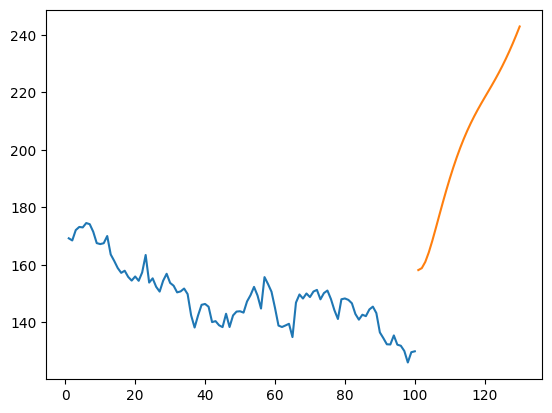

In [125]:
plt.plot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

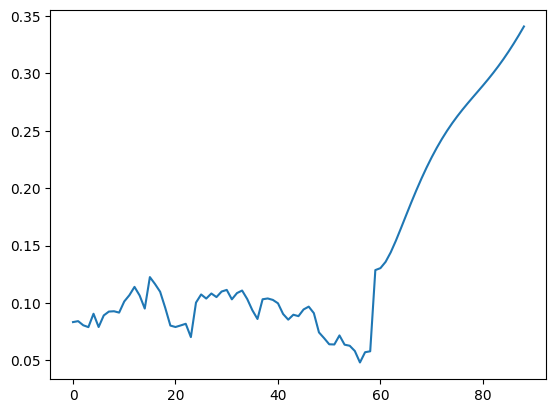

In [126]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

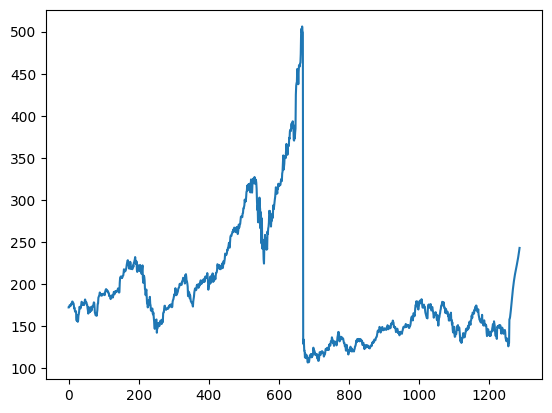

In [127]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)